[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Wind Turbine Structural Health Monitoring**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

This notebook, you will learn to train a custom yolo model for detecting damages in wind turbine for structural health monitoring.

## Annotate your Custom dataset using Labellerr

 ***1. Visit the [Labellerr](https://www.labellerr.com/?utm_source=githubY&utm_medium=social&utm_campaign=github_clicks) website and click **“Sign Up”**.*** 

 ***2. After signing in, create your workspace by entering a unique name.***

 ***3. Navigate to your workspace’s API keys page (e.g., `https://<your-workspace>.labellerr.com/workspace/api-keys`) to generate your **API Key** and **API Secret**.***

 ***4. Store the credentials securely, and then use them to initialise the SDK or API client with `api_key`, `api_secret`.*** 


### Use Labellerr SDK for uploading and perform annotation of your own dataset

In [ ]:
# uncomment the following lines to install required packages in a Jupyter notebook environment

# !pip install git+https://github.com/Labellerr/SDKPython.git
# !pip install ipyfilechooser
# !git clone https://github.com/Labellerr/yolo_finetune_utils.git

In [ ]:
# all the imports required for this notebook
from labellerr.client import LabellerrClient
from labellerr.core.datasets import create_dataset_from_local
from labellerr.core.annotation_templates import create_template
from labellerr.core.projects import create_project
from labellerr.core.schemas import DatasetConfig, AnnotationQuestion, QuestionType, CreateTemplateParams, DatasetDataType, CreateProjectParams, RotationConfig
from labellerr.core.projects import LabellerrProject
from labellerr.core.exceptions import LabellerrError

import uuid
from ipyfilechooser import FileChooser

In [ ]:
api_key = input("YOUR_API_KEY")        # go to labellerr workspace to get your API key
api_secret = input("YOUR_API_SECRET")  # go to labellerr workspace to get your API secret
client_id = input("YOUR_CLIENT_ID")   # Contact labellerr support to get your client ID i.e. support@tensormatics.com

client = LabellerrClient(api_key, api_secret, client_id)


### ***STEP-1: Create a dataset on labellerr from your local folder***

The SDK supports in creating dataset by uploading local files. 

In [ ]:
# Create a folder chooser starting from a directory (for example, your home directory)
chooser = FileChooser('/')

# Set the chooser to folder selection mode only
chooser.title = 'Select a folder containing your dataset'
chooser.show_only_dirs = True

# Display the widget
display(chooser)

FileChooser(path='D:\', filename='', title='Select a folder containing your dataset', show_hidden=False, selec…

In [ ]:
path_to_dataset = chooser.selected_path
print("You selected:", path_to_dataset)

You selected: D:\Professional\Projects\Cell_Segmentation_using_YOLO\frames_output


In [ ]:
my_dataset_type = input("Enter your dataset type (video or image): ").lower()
print("Selected dataset type:", my_dataset_type)

Selected dataset type: video


In [ ]:
dataset = create_dataset_from_local(
    client=client,
    dataset_config=DatasetConfig(dataset_name="My Dataset", data_type="image"),
    folder_to_upload=path_to_dataset
)

print(f"Dataset created with ID: {dataset.dataset_id}")


### ***STEP-2: Create annotation project on labellerr of your created dataset***

Create a annotation project of your uploaded dataset to start performing annotation on labellerr UI

In [ ]:
# Create annotation guideline template for video annotation project (like classes to be annotated)

template = create_template(
    client=client,
    params=CreateTemplateParams(
        template_name="My Template",
        data_type=DatasetDataType.image,
        questions=[
            AnnotationQuestion(
                question_number=1,
                question="Object",
                question_id=str(uuid.uuid4()),
                question_type=QuestionType.polygon,
                required=True,
                color="#FF0000"
            )
        ]
    )
)
print(f"Annotation template created with ID: {template.annotation_template_id}")


In [ ]:
dataset.status()        # wait until dataset is processed before creating project

project = create_project(
    client=client,
    params=CreateProjectParams(
        project_name="My Project",
        data_type=DatasetDataType.image,
        rotations=RotationConfig(
            annotation_rotation_count=1,
            review_rotation_count=1,
            client_review_rotation_count=1
        )
    ),
    datasets=[dataset],
    annotation_template=template
)

print(f"✓ Project created: {project.project_id}")

Your project has been created now go to labellerr platform to perform annotation 

***click to go to labellerr.com***

[![Labellerr](https://cdn.labellerr.com/1%20%20Documentation/1c9dc7ce-9a54-4111-8fd5-0363ba3e00e1.webp)](https://www.labellerr.com/?utm_source=githubY&utm_medium=social&utm_campaign=github_clicks)
Open the project you created (Projects → select your project).

Click Start Labeling to open the annotation interface. Use the configured labeling tools (bounding boxes, polygon, dot, classification, etc.) to annotate files.
### ***STEP-3: Export your annotation in required format***

Generate a temporary download URL to retrieve your exported JSON file:

### Export Configuration Parameters

| Parameter | Type | Description |
|-----------|------|-------------|
| `export_name` | string | Display name for the export |
| `export_description` | string | Description of what this export contains |
| `export_format` | string | Output format (e.g., `json`, `xml`, `coco`) |
| `statuses` | list | Annotation statuses to include in export |

### Common Annotation Statuses

- **`review`**: Annotations pending review
- **`r_assigned`**: Review assigned to a reviewer
- **`client_review`**: Under client review
- **`cr_assigned`**: Client review assigned
- **`accepted`**: Annotations accepted and finalized

---

In [ ]:
export_config = {
    "export_name": "Weekly Export",
    "export_description": "Export of all accepted annotations",
    "export_format": "coco_json",
    "statuses": ['review', 'r_assigned','client_review', 'cr_assigned','accepted']
}

try:
    # Get project instance
    project = LabellerrProject(client=client, project_id=project.project_id)
    
    # Create export
    result = project.create_local_export(export_config)
    export_id = result["response"]['report_id']
    print(f"Local export created successfully. Export ID: {export_id}")
except LabellerrError as e:
    print(f"Local export creation failed: {str(e)}")
    
    
try:
    download_url = client.fetch_download_url(
        project_id=project.project_id,
        uuid=str(uuid.uuid4()),
        export_id=export_id
    )
    print(f"Download URL: {download_url}")
except LabellerrError as e:
    print(f"Failed to fetch download URL: {str(e)}")


Now you can download your annotations locally using given URL

## Convert COCO Annotations to YOLO Format
Transform the COCO JSON annotation format to YOLO format and organize the dataset for training with proper directory structure.

In [ ]:
from yolo_finetune_utils.coco_yolo_converter.seg_converter import coco_to_yolo_converter

ANNOTATION_JSON = r"annotation.json"
IMAGE_DIR = r"Wind_Turbine_Damage\dataset"


coco_to_yolo_converter(
        json_path=ANNOTATION_JSON,
        images_dir=IMAGE_DIR,
        output_dir="yolo_dataset",
        use_split=False,
        train_ratio=1,
        val_ratio=0.0,
        test_ratio=0.0,
        shuffle=True,
        verbose=False
    )

## GPU Memory Management
Clear GPU cache and monitor memory allocation to ensure sufficient VRAM for model training.

In [ ]:
import torch
torch.cuda.empty_cache()

# Check GPU memory status
print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"Cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
print(f"Free: {torch.cuda.mem_get_info(0)[0]/1024**3:.2f} GB")

## Train YOLO Segmentation Model
Fine-tune the YOLOv11m segmentation model on the dataset for 300 epochs with GPU acceleration.

In [ ]:
from ultralytics import YOLO
# Load a model
model = YOLO("yolo11m-seg.pt")

# Train the model
results = model.train(
    data=r"yolo_dataset\data.yaml",    # Path to your dataset YAML file
    epochs=300,                        # Number of training epochs
    imgsz=640,                         # Image size
    batch=-1,                          # Batch size
    device=0,                          # GPU device (0 for first GPU, 'cpu' for CPU)
    workers=6                          # Number of dataloader workers
)

## Load Best Trained Model
Set the path to the best model weights from the training run for inference.

In [ ]:
MODEL_PATH = r"runs\segment\train\weights\best.pt"

## Define Inference Function
Create a function to perform segmentation inference on images

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import cv2

def show_segmentation(image_path, model_path=MODEL_PATH, alpha=0.5, figsize=(12, 8)):
    """
    Display YOLO segmentation results with overlay using matplotlib in a notebook.
    
    Args:
        image_path: Path to input image
        model_path: Path to YOLO segmentation model
        alpha: Transparency of the overlay (0.0 to 1.0)
        figsize: Figure size as (width, height)
    """
    # Load model and run inference
    model = YOLO(model_path)
    results = model.predict(source=image_path, conf=0.2)
    
    # Get the original image (convert BGR to RGB for matplotlib)
    img = cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB)
    
    # Create overlay
    overlay = np.zeros_like(img)
    
    # Process each detection
    for result in results:
        if result.masks is not None:
            masks = result.masks.data.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            
            for mask, cls in zip(masks, classes):
                # Resize mask to image dimensions
                mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
                
                # Generate random color
                color = np.random.randint(0, 255, size=3)
                
                # Apply color to overlay where mask exists
                overlay[mask_resized > 0.5] = color
    
    # Blend images
    result_img = (img * (1 - alpha) + overlay * alpha).astype(np.uint8)
    
    # Display with matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(result_img)
    plt.axis('off')
    plt.title('DAMAGE DETECTIONS')
    plt.tight_layout()
    plt.show()
    
    return result_img


def show_segmentation_comparison(image_path, model_path=MODEL_PATH, alpha=0.5):
    """Display original and segmented images side by side."""
    model = YOLO(model_path)
    results = model.predict(source=image_path, conf=0.2)
    
    img = cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB)
    overlay = np.zeros_like(img)
    
    for result in results:
        if result.masks is not None:
            masks = result.masks.data.cpu().numpy()
            
            for mask in masks:
                mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
                color = np.random.randint(0, 255, size=3)
                overlay[mask_resized > 0.5] = color
    
    result_img = (img * (1 - alpha) + overlay * alpha).astype(np.uint8)
    
    # Create side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(result_img)
    axes[1].set_title('Damage Overlay')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()



## Test Inference on Sample Image 1
Run segmentation inference on the image and visualize the results.


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_1.jpg: 640x640 2 damages, 16.9ms
Speed: 3.0ms preprocess, 16.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


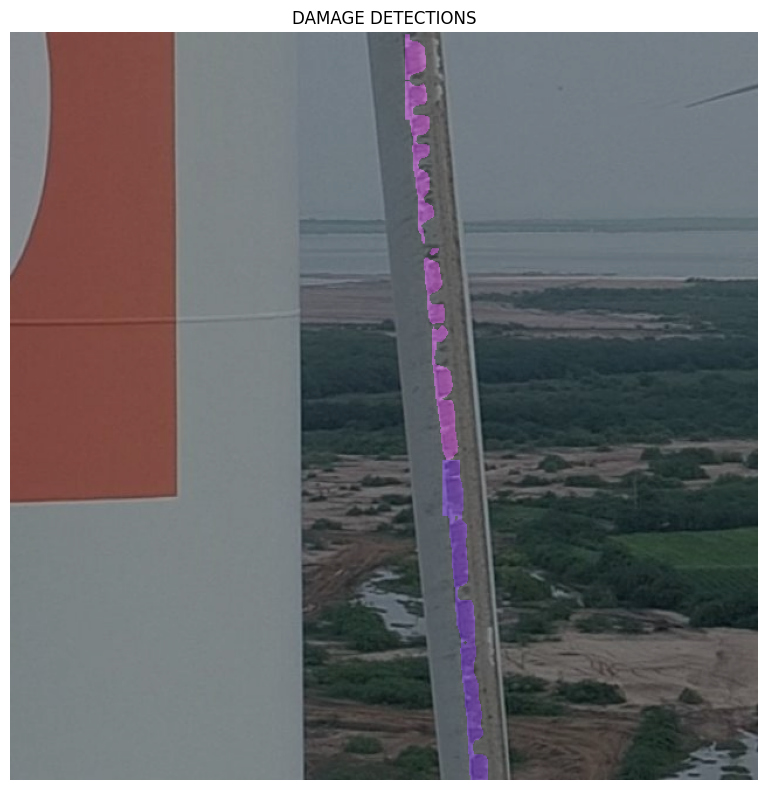


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_1.jpg: 640x640 2 damages, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


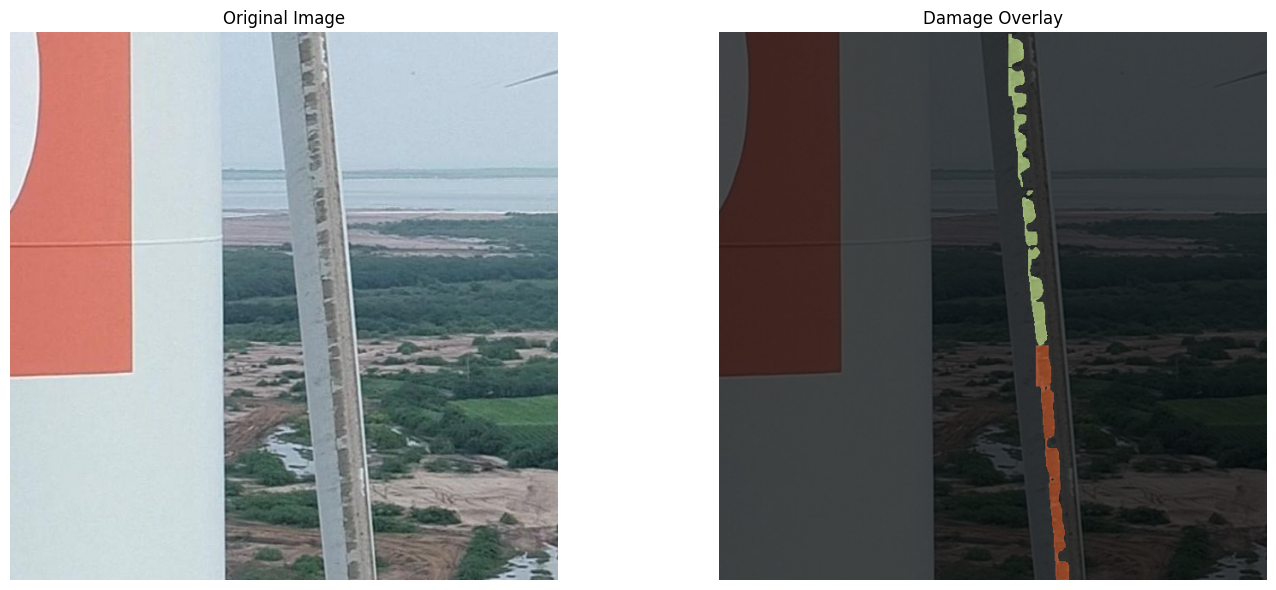

In [11]:
TEST_IMG_PATH = r"test_sample\test_img_1.jpg"
# Usage in notebook
result = show_segmentation(TEST_IMG_PATH, alpha=0.4)
show_segmentation_comparison(TEST_IMG_PATH, alpha=0.7)

## Test Inference on Sample Image 2
Run segmentation inference on the image and visualize the results.


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_1.jpg: 640x640 2 damages, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


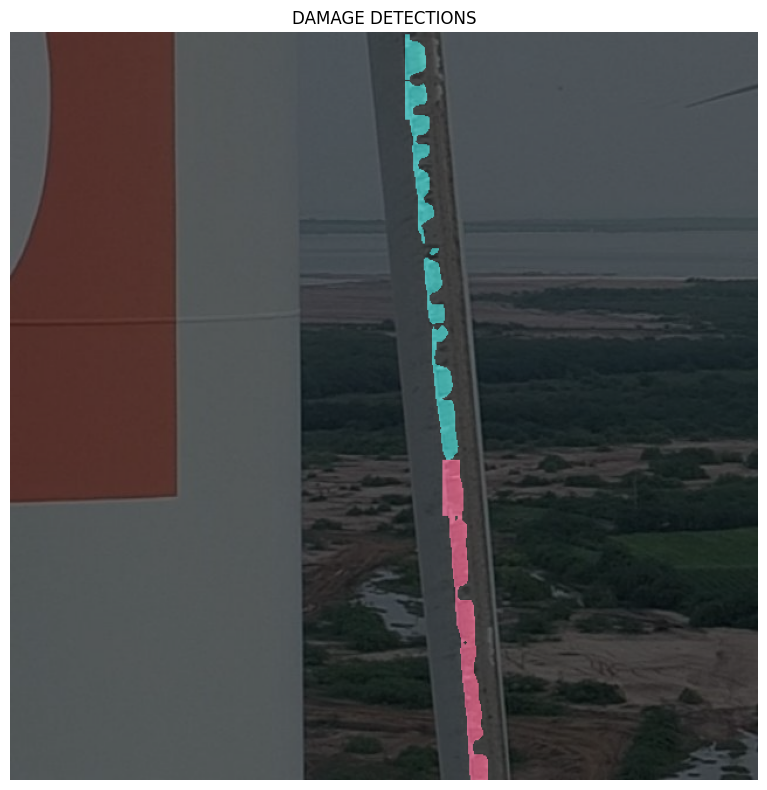


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_1.jpg: 640x640 2 damages, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


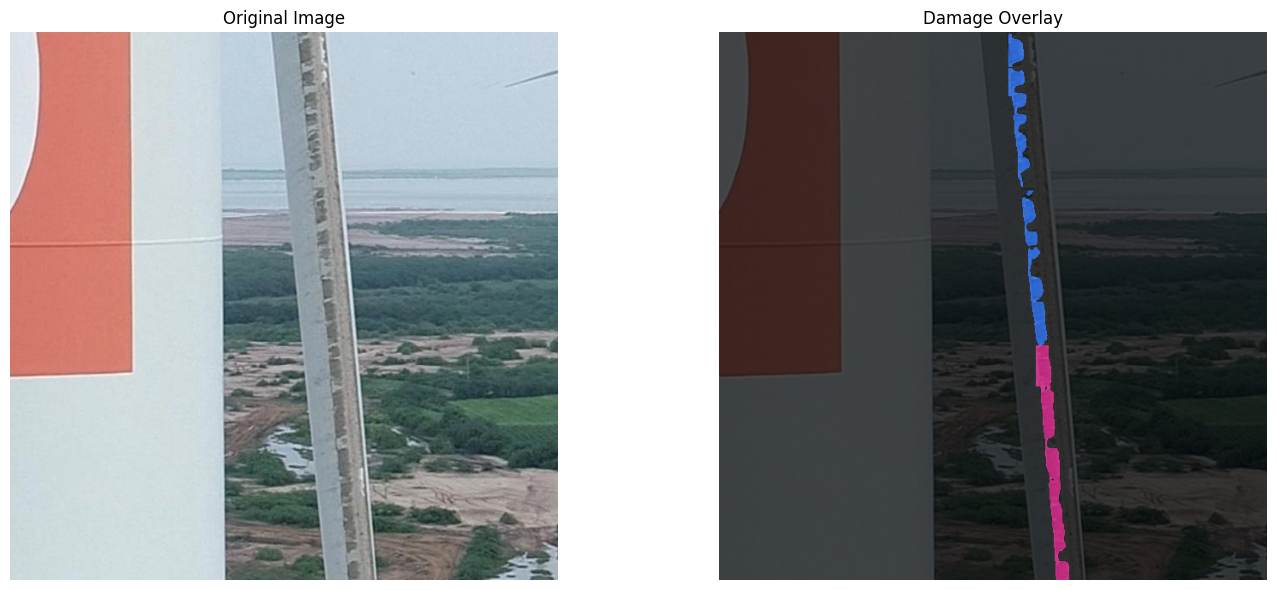

In [12]:
TEST_IMG_PATH = r"test_sample\test_img_1.jpg"
# Usage example
result = show_segmentation(TEST_IMG_PATH, alpha=0.6)
show_segmentation_comparison(TEST_IMG_PATH, alpha=0.7)

## Test Inference on Sample Image 3
Run segmentation inference on the image and visualize the results


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_3.jpg: 640x640 2 damages, 16.6ms
Speed: 2.8ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


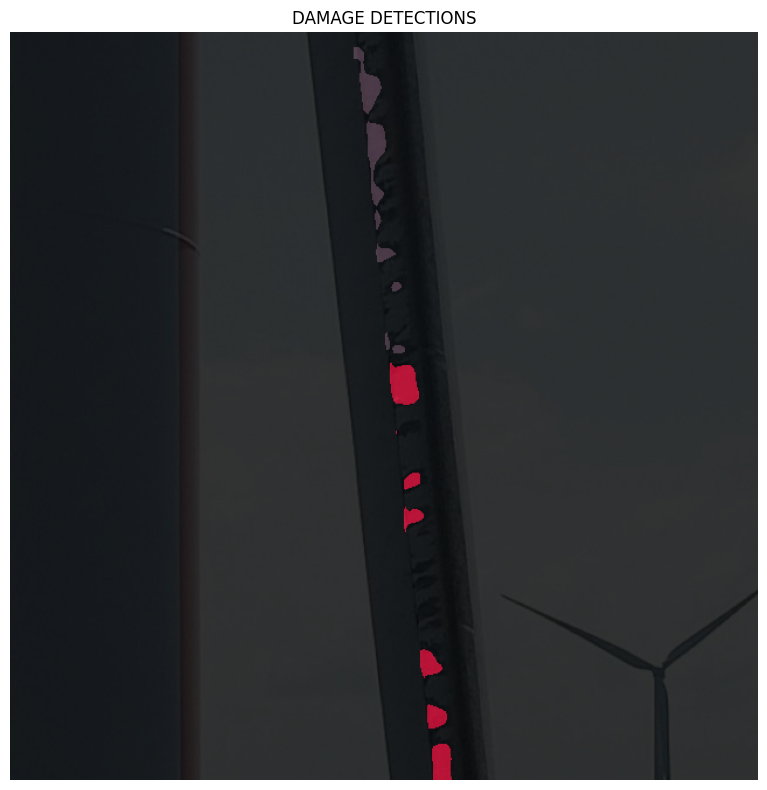


image 1/1 d:\Professional\Projects\Wind_Turbine_Damage_Detection\test_sample\test_img_3.jpg: 640x640 2 damages, 11.3ms
Speed: 3.2ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


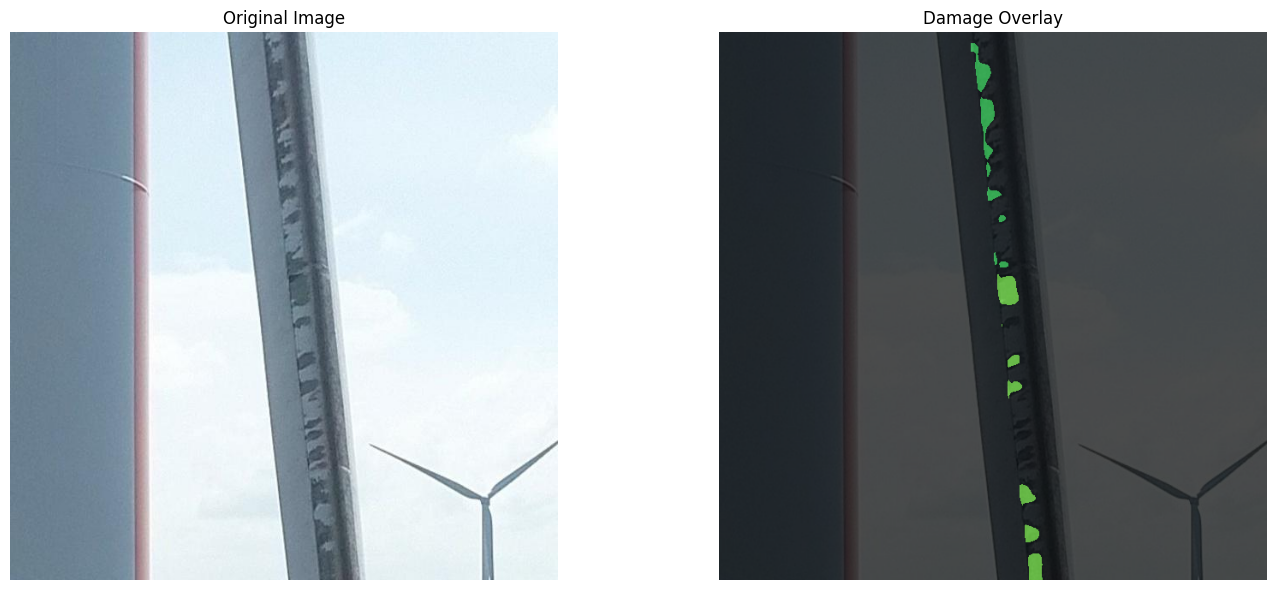

In [13]:
TEST_IMG_PATH = r"test_sample\test_img_3.jpg"
# Usage in notebook
result = show_segmentation(TEST_IMG_PATH, alpha=0.8)
show_segmentation_comparison(TEST_IMG_PATH, alpha=0.7)

---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
